In [2]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import pandas as pd
import time
import yfinance as yf
import csv
from gnews import GNews
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from dateutil import parser
import os
import dateparser
from GoogleNews import GoogleNews

In [3]:
def get_financial_reports(ticker_symbol):
    ticker = yf.Ticker(ticker_symbol)

    balance_sheet = ticker.balance_sheet
    income_statement = ticker.financials
    cash_flow = ticker.cashflow
    
    # Convert to DataFrame and transpose for better readability
    balance_sheet_df = balance_sheet.T
    income_statement_df = income_statement.T
    cash_flow_df = cash_flow.T

    # Define the directory to save the files
    save_dir = r"C:\Users\Lenovo\Documents\Projects\web_scraping_model2.1\Financial_reports"
    
    # Ensure the directory exists
    os.makedirs(save_dir, exist_ok=True)
    
    # Save the DataFrames to CSV files in the specified directory
    balance_sheet_df.to_csv(os.path.join(save_dir, f'{ticker_symbol}_balance_sheet.csv'))
    income_statement_df.to_csv(os.path.join(save_dir, f'{ticker_symbol}_income_statement.csv'))
    cash_flow_df.to_csv(os.path.join(save_dir, f'{ticker_symbol}_cash_flow.csv'))

    print(f'Financial reports for {ticker_symbol} have been saved to CSV files in {save_dir}.')

get_financial_reports('AAPL')
get_financial_reports('AMZN')

Financial reports for AAPL have been saved to CSV files in C:\Users\Lenovo\Documents\Projects\web_scraping_model2.1\Financial_reports.
Financial reports for AMZN have been saved to CSV files in C:\Users\Lenovo\Documents\Projects\web_scraping_model2.1\Financial_reports.


In [4]:
def fetch_news(ticker, start_date, end_date, limit=100):
    google_news = GNews()
    search = google_news.get_news(ticker)
    
    news_data = []
    for article in search[:limit]:
        headline = article.get('title', 'No Title')
        link = article.get('url', 'No URL')
        summary = article.get('description', 'No Description')
        published_date_str = article.get('published date', None)
        
        if published_date_str:
            published_date = dateparser.parse(published_date_str)
            if published_date:
                published_date = published_date.date()
            else:
                published_date = 'No Date'
        else:
            published_date = 'No Date'
        
        news_data.append({
            'headline': headline,
            'summary': summary,
            'link': link,
            'published_date': published_date  # Add published_date to the dictionary
        })
    
    if news_data:
        keys = news_data[0].keys()
        # Define the directory to save the files
        save_dir = r"C:\Users\Lenovo\Documents\Projects\web_scraping_model2.1\news"
        
        # Ensure the directory exists
        os.makedirs(save_dir, exist_ok=True)
        
        # Save the CSV files in the specified directory
        file_path = os.path.join(save_dir, f'{ticker}_news.csv')
        with open(file_path, 'w', newline='', encoding='utf-8') as output_file:
            dict_writer = csv.DictWriter(output_file, fieldnames=keys)
            dict_writer.writeheader()
            dict_writer.writerows(news_data)
    else:
        print(f'No news data found for {ticker}')
        
    return news_data

# Fetch news for Amazon and Apple
amzn_news = fetch_news("Amazon", "2010-01-01", "2024-01-01")
aapl_news = fetch_news("Apple", "2010-01-01", "2024-01-01")

# Convert to DataFrame for better visualization
amzn_news_df = pd.DataFrame(amzn_news)
aapl_news_df = pd.DataFrame(aapl_news)

print("Amazon News")
print(amzn_news_df)

print("\nApple News")
print(aapl_news_df)

Amazon News
                                             headline  \
0   Amazon removes Prime Video film – after just o...   
1   Amazon removes Prime Video film after one Ofco...   
2   Amazon Falls Foul Of Ofcom Code For First Time...   
3   The 10 Best Dr. Scholl's Shoe Deals at Amazon ...   
4   Amazon's Most Popular Home Trends Start at $5 ...   
..                                                ...   
95  Jeff Bezos Sells 1.1 Million Amazon (AMZN) Sha...   
96  Walgreens Joins Target, Amazon, Walmart In Ann...   
97  Amazon EC2 high memory U7i Instances for large...   
98  Primavera Sound 2024 Amazon Music Livestream S...   
99  Amazon MGM Studios Taps Lauren Anderson to Con...   

                                              summary  \
0   Amazon removes Prime Video film – after just o...   
1   Amazon removes Prime Video film after one Ofco...   
2   Amazon Falls Foul Of Ofcom Code For First Time...   
3   The 10 Best Dr. Scholl's Shoe Deals at Amazon ...   
4   Amazon's Most 

In [5]:
sia = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    scores = sia.polarity_scores(text)
    if scores['compound'] >= 0.05:
        return 'Positive'
    elif scores['compound'] <= -0.05:
        return "Negative"
    else:
        return 'Neutral'

# Define the paths to the CSV files
amzn_news_path = r"C:\Users\Lenovo\Documents\Projects\web_scraping_model2.1\news\Amazon_news.csv"
aapl_news_path = r"C:\Users\Lenovo\Documents\Projects\web_scraping_model2.1\news\Apple_news.csv"

# Read the CSV files into DataFrames
amzn_news_df = pd.read_csv(amzn_news_path)
aapl_news_df = pd.read_csv(aapl_news_path)

# Apply sentiment analysis to the 'summary' column and create a new 'Sentiment' column
amzn_news_df['Sentiment'] = amzn_news_df['summary'].apply(analyze_sentiment)
aapl_news_df['Sentiment'] = aapl_news_df['summary'].apply(analyze_sentiment)

# Save the updated DataFrames back to the CSV files
amzn_news_df.to_csv(amzn_news_path, index=False)
aapl_news_df.to_csv(aapl_news_path, index=False)

# Print the sentiment analysis results
print("Amazon News Sentiment Analysis:")
print(amzn_news_df['Sentiment'].value_counts())

print("\nApple News Sentiment Analysis:")
print(aapl_news_df['Sentiment'].value_counts())


Amazon News Sentiment Analysis:
Sentiment
Positive    75
Negative    19
Neutral      6
Name: count, dtype: int64

Apple News Sentiment Analysis:
Sentiment
Neutral     41
Positive    39
Negative    20
Name: count, dtype: int64


In [6]:
amzn_stock = yf.download("AMZN", start='2010-01-01', end='2024-01-01')
aapl_stock = yf.download("AAPL", start='2010-01-01', end='2024-01-01')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [7]:
def calculate_moving_averages(df, window):
    df[f"SMA_{window}"] = df['Close'].rolling(window=window).mean()
    return df

amzn_stock = calculate_moving_averages(amzn_stock, 50)
amzn_stock = calculate_moving_averages(amzn_stock, 200)
aapl_stock = calculate_moving_averages(aapl_stock, 50)
aapl_stock = calculate_moving_averages(aapl_stock, 200)

In [8]:
def calculate_volatility(df, window):
    df['Volatility'] = df['Close'].rolling(window=window).std()
    return df

amzn_stock = calculate_volatility(amzn_stock, 30)
aapl_stock = calculate_volatility(aapl_stock, 30)

In [10]:
def calculate_rsi(df, window):
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0,0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0,0)).rolling(window=window).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    return df

amzn_stock = calculate_rsi(amzn_stock, 14)
aapl_stock = calculate_rsi(aapl_stock, 14)

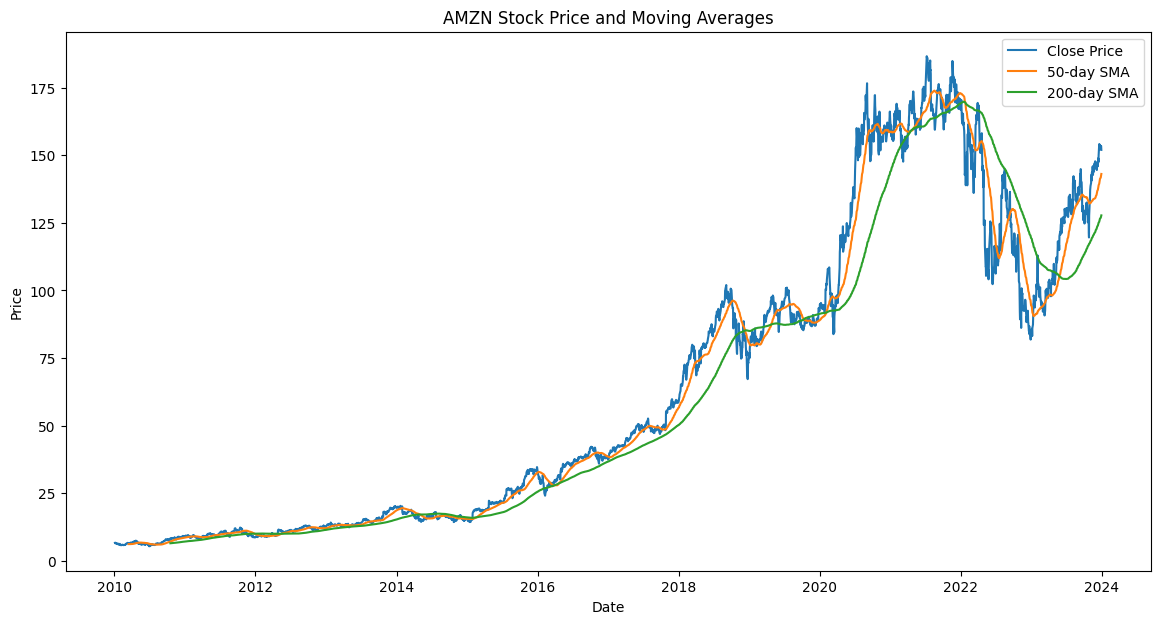

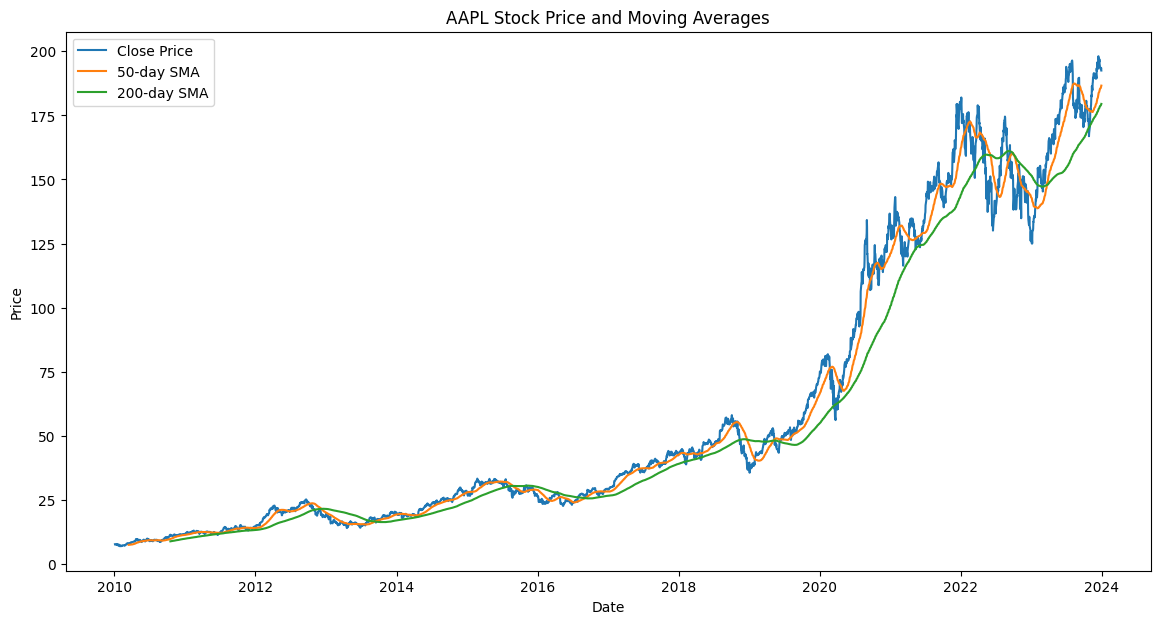

In [11]:
def plot_stock_data (df, ticker):
    plt.figure(figsize=(14, 7))
    plt.plot(df['Close'], label='Close Price')
    plt.plot(df['SMA_50'], label='50-day SMA')
    plt.plot(df['SMA_200'], label='200-day SMA')
    plt.title(f'{ticker} Stock Price and Moving Averages')
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

plot_stock_data(amzn_stock, 'AMZN')
plot_stock_data(aapl_stock, 'AAPL')

In [14]:
amazon_files  = {
    "balance_sheet": r"C:\Users\Lenovo\Documents\Projects\web_scraping_model2.1\financial_reports\AAPL_balance_sheet.csv",
    "cash_flow": r"C:\Users\Lenovo\Documents\Projects\web_scraping_model2.1\financial_reports\AAPL_cash_flow.csv",
    "income_sheet": r"C:\Users\Lenovo\Documents\Projects\web_scraping_model2.1\financial_reports\AAPL_income_statement.csv"
    
}

apple_files = {
    "balance_sheet": r"C:\Users\Lenovo\Documents\Projects\web_scraping_model2.1\financial_reports\AMZN_balance_sheet.csv",
    "cash_flow": r"C:\Users\Lenovo\Documents\Projects\web_scraping_model2.1\financial_reports\AMZN_cash_flow.csv",
    "income_statement": r"C:\Users\Lenovo\Documents\Projects\web_scraping_model2.1\financial_reports\AMZN_income_statement.csv",
    
}    
    
   

amazon_data = {key: pd.read_csv(path) for key, path in amazon_files.items()}
apple_data = {key: pd.read_csv(path) for key, path in apple_files.items()}

In [15]:
def clean_data(df):

    df = df.drop_duplicates()

    df = df.ffill().bfill()

    for col in df.columns:
        if 'date' in col.lower():
            df[col] = pd.to_datetime(df[col], errors='coerce')
    
    return df

amazon_data = {key : clean_data(df) for key, df in amazon_data.items()}
apple_data = {key: clean_data(df) for key, df in apple_data.items()}

In [16]:
def normalize_data(df):

    num_cols = df.select_dtypes(include=[np.number]).columns

    scaler = StandardScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])

    return df

amazon_data = {key: normalize_data(df) for key, df in amazon_data.items()}
apple_data = {key: normalize_data(df) for key, df in apple_data.items()}


In [17]:
def save_data(data_dict, prefix):
    for key, df in data_dict.items():
        df.to_csv(f'C:\\Users\Lenovo\Documents\Projects\web_scraping_model2.1\\financial_reports_cleaned\\{prefix}_{key}_cleaned.csv', index=False)

save_data(amazon_data, 'Amazon')
save_data(apple_data, 'Apple')

<>:3: SyntaxWarning: invalid escape sequence '\L'
<>:3: SyntaxWarning: invalid escape sequence '\L'
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21432\4061274188.py:3: SyntaxWarning: invalid escape sequence '\L'
  df.to_csv(f'C:\\Users\Lenovo\Documents\Projects\web_scraping_model2.1\\financial_reports_cleaned\\{prefix}_{key}_cleaned.csv', index=False)


In [18]:
amzn_balance_sheet = pd.read_csv(r'C:\Users\Lenovo\Documents\Projects\web_scraping_model2.1\financial_reports_cleaned\Amazon_balance_sheet_cleaned.csv')
aapl_balance_sheet = pd.read_csv(r'C:\Users\Lenovo\Documents\Projects\web_scraping_model2.1\financial_reports_cleaned\Apple_balance_sheet_cleaned.csv')


In [19]:
amzn_income_statement = pd.read_csv(r'C:\Users\Lenovo\Documents\Projects\web_scraping_model2.1\financial_reports_cleaned\Amazon_income_sheet_cleaned.csv')
aapl_income_statement = pd.read_csv(r'C:\Users\Lenovo\Documents\Projects\web_scraping_model2.1\financial_reports_cleaned\Apple_income_statement_cleaned.csv')

In [20]:
amzn_balance_sheet['Unnamed: 0'] = pd.to_datetime(amzn_balance_sheet['Unnamed: 0'], errors='coerce')
aapl_balance_sheet['Unnamed: 0'] = pd.to_datetime(aapl_balance_sheet['Unnamed: 0'], errors='coerce')


In [21]:
amzn_balance_sheet.set_index('Unnamed: 0', inplace=True)
aapl_balance_sheet.set_index('Unnamed: 0', inplace=True)

In [22]:
aapl_income_statement.set_index('Unnamed: 0', inplace=True)
amzn_income_statement.set_index('Unnamed: 0', inplace=True)

In [23]:
amzn_income_statement.index = pd.to_datetime(amzn_income_statement.index, errors='coerce')
aapl_income_statement.index = pd.to_datetime(aapl_income_statement.index, errors='coerce')


In [25]:
def align_days_to_balance_sheet_and_income_statement(balance_sheet, income_statement):
    # Ensure the dates are in datetime format
    balance_sheet.index = pd.to_datetime(balance_sheet.index)
    income_statement.index = pd.to_datetime(income_statement.index)

    # Adjust the day in the balance sheet dates to the 30th of September
    aligned_balance_sheet_dates = balance_sheet.index.map(lambda date: date.replace(month=9, day=30))
    balance_sheet.index = aligned_balance_sheet_dates

    # Adjust the day in the income statement dates to the 30th of September
    aligned_income_statement_dates = income_statement.index.map(lambda date: date.replace(month=9, day=30))
    income_statement.index = aligned_income_statement_dates

    # Print aligned dates for debugging
    print("Aligned Balance Sheet Dates:")
    print(balance_sheet.index)
    print("Aligned Income Statement Dates:")
    print(income_statement.index)

    return balance_sheet, income_statement

# Align days for Apple
print("Aligning dates for Apple...")
aapl_balance_sheet, aapl_income_statement = align_days_to_balance_sheet_and_income_statement(aapl_balance_sheet, aapl_income_statement)

Aligning dates for Apple...
Aligned Balance Sheet Dates:
DatetimeIndex(['2023-09-30', '2022-09-30', '2021-09-30', '2020-09-30',
               '2019-09-30'],
              dtype='datetime64[ns]', name='Unnamed: 0', freq=None)
Aligned Income Statement Dates:
DatetimeIndex(['2023-09-30', '2022-09-30', '2021-09-30', '2020-09-30',
               '2019-09-30'],
              dtype='datetime64[ns]', name='Unnamed: 0', freq=None)


In [26]:
def merge_aligned_dataframes(balance_sheet, income_statement):
    merged_df = balance_sheet.merge(income_statement, left_index=True, right_index=True, suffixes=('_balance', '_income'), indicator=True)
    return merged_df

# Merge data for Amazon
try:
    print("Merging data for Amazon...")
    amzn_merged = merge_aligned_dataframes(amzn_balance_sheet, amzn_income_statement)
    print("Merged Data for Amazon:")
    print(amzn_merged)
except ValueError as e:
    print(f"Error merging data for Amazon: {e}")
except KeyError as e:
    print(f"KeyError merging data for Amazon: {e}")

# Merge data for Apple
try:
    print("Merging data for Apple...")
    aapl_merged = merge_aligned_dataframes(aapl_balance_sheet, aapl_income_statement)
    print("Merged Data for Apple:")
    print(aapl_merged)
except ValueError as e:
    print(f"Error merging data for Apple: {e}")
except KeyError as e:
    print(f"KeyError merging data for Apple: {e}")

# Check the merge indicator to understand the merge result
print("Merge Indicator for Amazon:")
print(amzn_merged['_merge'].value_counts())

print("Merge Indicator for Apple:")
print(aapl_merged['_merge'].value_counts())


Merging data for Amazon...
Merged Data for Amazon:
            Treasury Shares Number  Ordinary Shares Number  Share Issued  \
Unnamed: 0                                                                 
2023-09-30                     0.0               -1.460754     -1.460754   
2022-09-30                     0.0               -0.764005     -0.764005   
2021-09-30                     0.0                0.092152      0.092152   
2020-09-30                     0.0                1.066303      1.066303   

            Net Debt  Total Debt  Tangible Book Value  Invested Capital  \
Unnamed: 0                                                                
2023-09-30 -0.243118   -0.949800             0.151570         -0.725271   
2022-09-30  1.519778    0.735468            -1.946788         -1.152435   
2021-09-30  0.754243    1.608032             0.324209          1.772089   
2020-09-30 -1.015452   -0.696850             0.735504          0.052809   

            Working Capital  Net Tangible

In [27]:
def extract_data(balance_sheet, income_statement, year):
    year_date = pd.to_datetime(year, format='%Y-%m-%d', errors='coerce')
    if year_date not in balance_sheet.index or year_date not in income_statement.index:
        raise KeyError(f"Date {year_date} not found in DataFrame index.")
    
    current_assets = balance_sheet.loc[year_date, 'Current Assets']
    current_liabilities = balance_sheet.loc[year_date, 'Current Liabilities']
    total_liabilities = balance_sheet.loc[year_date, 'Total Liabilities Net Minority Interest']
    stockholders_equity = balance_sheet.loc[year_date, 'Stockholders Equity']
    net_income = income_statement.loc[year_date, 'Net Income']
    shares_outstanding = income_statement.loc[year_date, 'Diluted Average Shares']
    
    return current_assets, current_liabilities, total_liabilities, stockholders_equity, net_income, shares_outstanding


In [28]:
def calculate_ratios(balance_sheet, income_statement, year):
    try:
        current_assets, current_liabilities, total_liabilities, stockholders_equity, net_income, shares_outstanding = extract_data(balance_sheet, income_statement, year)
        
        pe_ratio = net_income / shares_outstanding
        debt_to_equity = total_liabilities / stockholders_equity
        roe = net_income / stockholders_equity
        
        return {
            'PE_Ratio': pe_ratio,
            'Debt_to_Equity': debt_to_equity,
            'ROE': roe
        }
    except KeyError as e:
        print(f"Skipping calculation for {year}: {e}")
        return None

In [29]:
# List of years to calculate ratios for
years = ['2023-09-30', '2022-09-30', '2021-09-30', '2020-09-30']

# Calculate ratios for Amazon
amzn_ratios = {year: calculate_ratios(amzn_balance_sheet, amzn_income_statement, year) for year in years if calculate_ratios(amzn_balance_sheet, amzn_income_statement, year) is not None}

# Calculate ratios for Apple
aapl_ratios = {year: calculate_ratios(aapl_balance_sheet, aapl_income_statement, year) for year in years if calculate_ratios(aapl_balance_sheet, aapl_income_statement, year) is not None}

In [32]:
# Function to convert ratios to DataFrame
def ratios_to_dataframe(ratios):
    df = pd.DataFrame(ratios).T
    df.index.name = 'Year'
    return df

# Convert ratios to DataFrame for Amazon and Apple
amzn_ratios_df = ratios_to_dataframe(amzn_ratios)
aapl_ratios_df = ratios_to_dataframe(aapl_ratios)

# Function to display ratios
def display_ratios(ratios_df, company_name):
    print(f"Financial Ratios for {company_name}:")
    print(ratios_df)

# Display ratios for Amazon
display_ratios(amzn_ratios_df, 'Amazon')

# Display ratios for Apple
display_ratios(aapl_ratios_df, 'Apple')

Financial Ratios for Amazon:
            PE_Ratio  Debt_to_Equity       ROE
Year                                          
2023-09-30 -0.438429        4.059206  3.725494
2022-09-30 -1.507855       -0.652745 -0.373396
2021-09-30  1.182789        1.459354  1.329122
2020-09-30 -1.225358       -1.603761 -2.341944
Financial Ratios for Apple:
            PE_Ratio  Debt_to_Equity        ROE
Year                                           
2023-09-30  0.407381        0.708224   0.455530
2022-09-30  2.444380        3.382074  -6.490543
2021-09-30  4.815411        1.623545  10.944048
2020-09-30 -0.069753        1.120385  -0.044986


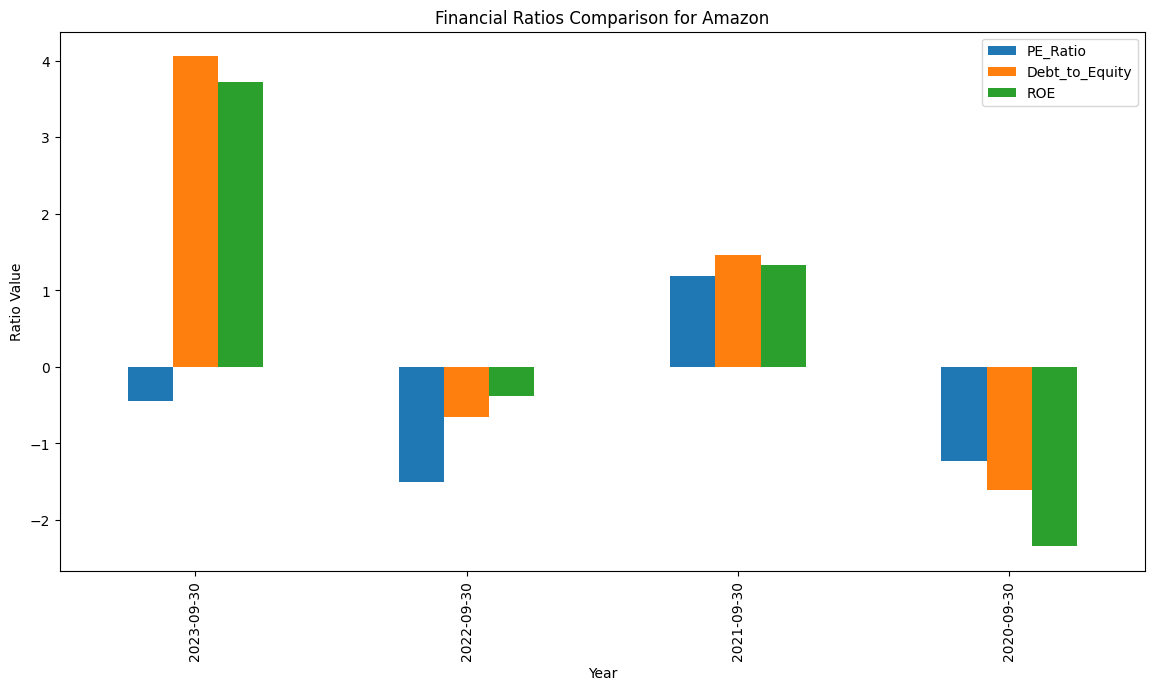

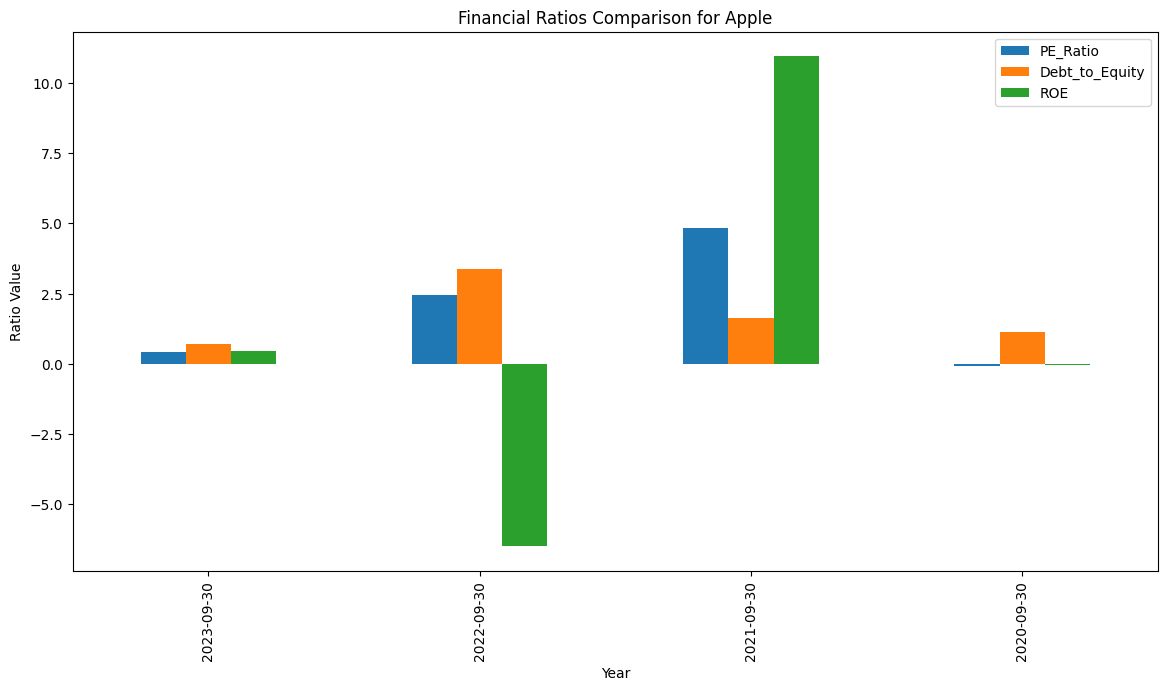

In [33]:
def compare_performance(ratios_df, company_name):
    ratios_df.plot(kind='bar', figsize=(14,7))
    plt.title(f'Financial Ratios Comparison for {company_name}')
    plt.xlabel('Year')
    plt.ylabel('Ratio Value')
    plt.legend(loc='best')
    plt.show()

compare_performance(amzn_ratios_df, 'Amazon')
compare_performance(aapl_ratios_df, 'Apple')